In [1]:
import pandas as pd
import numpy as np

# Introduction

In this project, we are going to predict an individual's MBTI personality type based on their chat history. This dataset is retrieved from Kaggle which was collected from the PersonalityCafe forum. The datasets contains only 2 columns: "type" and "posts". Each row represents an individual's MBTI type and a collection of their posts in the forum. With this dataset, we will be using NLP to preprocess the data and try out different models that will lead to the best performance.

My goal in this project is to be a lot more familiar with dealing with text data and state-of-the-art methods in NLP.

# Data Wrangling

In [2]:
mbti = pd.read_csv("mbti_1.csv")
mbti.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [3]:
mbti.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [4]:
mbti["type"].unique()

array(['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ'],
      dtype=object)

In [5]:
expanded_mbti = pd.merge(mbti["type"], mbti["posts"].str.split("|||", regex = False).explode().rename("post"), 
                         left_index = True, right_index = True)
expanded_mbti = expanded_mbti.reset_index(drop = True)
expanded_mbti.head()

,type,post
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw
1,INFJ,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...
2,INFJ,enfp and intj moments https://www.youtube.com...
3,INFJ,What has been the most life-changing experienc...
4,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...


In [6]:
expanded_mbti.shape

(422845, 2)

Fortunately, the MBTI dataset is a really clean dataset with no missing values. Each row represent a compilation of an individual's posts along with their MBTI type. The individual's posts are split by "|||" to distinguish one post from another. Thus, for data wrangling I split these into separate rows, completely disregarding who made these posts since we aim to predict MBTI type without knowledge of the individual and only based off their chats. This gives us a total of 422845 rows from the original 8675, approximating to 48.74 posts per person.

We can then proceed with EDA.

# Exploratory Data Analysis

<Axes: title={'center': 'Number of posts per MBTI type'}, xlabel='type'>

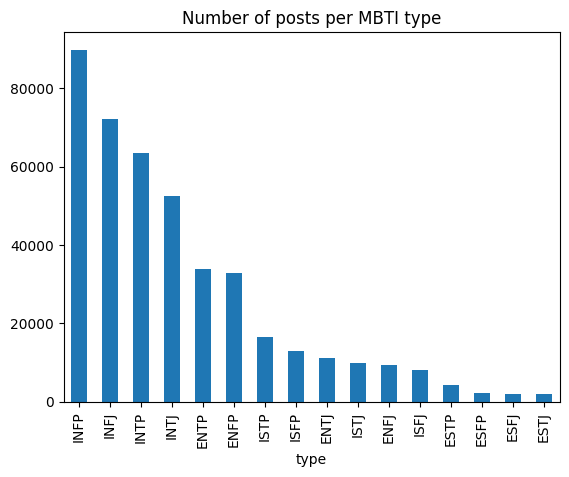

In [7]:
ax = expanded_mbti["type"].value_counts().plot(kind = 'bar', title = "Number of posts per MBTI type")
ax

In [8]:
# Expand table to have a letter per column
expanded_mbti["I/E"] = expanded_mbti["type"].str[0]
expanded_mbti["S/N"] = expanded_mbti["type"].str[1]
expanded_mbti["F/T"] = expanded_mbti["type"].str[2]
expanded_mbti["P/J"] = expanded_mbti["type"].str[3]

mbti["I/E"] = mbti["type"].str[0]
mbti["S/N"] = mbti["type"].str[1]
mbti["F/T"] = mbti["type"].str[2]
mbti["P/J"] = mbti["type"].str[3]

expanded_mbti.head()

,type,post,I/E,S/N,F/T,P/J
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw,I,N,F,J
1,INFJ,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...,I,N,F,J
2,INFJ,enfp and intj moments https://www.youtube.com...,I,N,F,J
3,INFJ,What has been the most life-changing experienc...,I,N,F,J
4,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...,I,N,F,J


In [9]:
pop_mbti = pd.Series([11.6, 13.8, 1.5, 2.1, 5.4, 8.8, 4.4, 3.3,
                     4.3, 8.5, 8.1, 3.2, 8.7, 12, 2.5, 1.8], 
                     index = ['ISTJ', 'ISFJ', 'INFJ', 'INTJ', 'ISTP', 'ISFP', 'INFP', 'INTP', 'ESTP',
                     'ESFP', 'ENFP', 'ENTP', 'ESTJ', 'ESFJ', 'ENFJ', 'ENTJ'])
pop_mbti.sort_values(ascending = False)

ISFJ    13.8
ESFJ    12.0
ISTJ    11.6
ISFP     8.8
ESTJ     8.7
ESFP     8.5
ENFP     8.1
ISTP     5.4
INFP     4.4
ESTP     4.3
INTP     3.3
ENTP     3.2
ENFJ     2.5
INTJ     2.1
ENTJ     1.8
INFJ     1.5
dtype: float64

type
INFP    21.1
INFJ    16.9
INTP    15.0
INTJ    12.6
ENTP     7.9
ENFP     7.8
ISTP     3.9
ISFP     3.1
ENTJ     2.7
ISTJ     2.4
ENFJ     2.2
ISFJ     1.9
ESTP     1.0
ESFP     0.6
ESFJ     0.5
ESTJ     0.4
Name: proportion, dtype: float64

<Axes: >

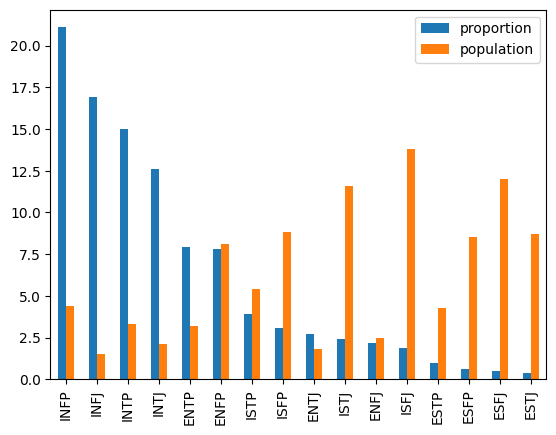

In [10]:
our_mbti = mbti["type"].value_counts(normalize = True).round(3) * 100
display(our_mbti)
pd.concat([our_mbti, pop_mbti], axis = 1).rename(columns = {"type": "sample", 0: "population"}).plot(kind = 'bar')

,sample,population
J,39.6,54.0
P,60.4,46.0
T,45.9,40.4
F,54.1,59.6
S,13.8,73.1
N,86.2,26.9
E,23.0,49.1
I,77.0,50.9


<Axes: >

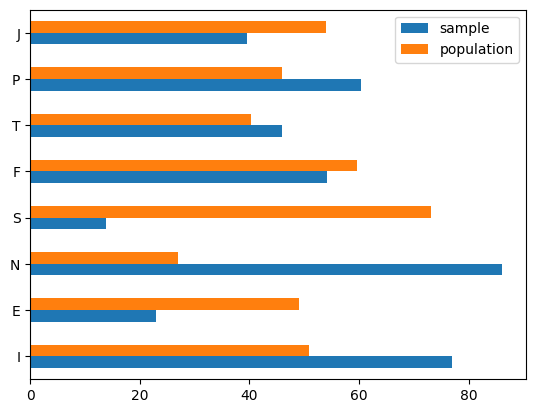

In [11]:
mbti["I/E"] = mbti["type"].str[0]
mbti["S/N"] = mbti["type"].str[1]
mbti["F/T"] = mbti["type"].str[2]
mbti["P/J"] = mbti["type"].str[3]
mbti_dist = pd.concat([mbti[col].value_counts(normalize = True) for col in expanded_mbti.iloc[:,-4:].columns], axis = 0)

pop_mbti = pop_mbti.reset_index()
pop_mbti[["a", "I/E", "S/N", "F/T", "P/J", "b"]] = pop_mbti["index"].str.split("", expand = True)
pop_mbti = pop_mbti.drop(columns = ["a", "b"])
pop_mbti = pop_mbti.rename(columns = {"index":"type", 0: "perc"})

pop_dist = pd.concat([pop_mbti.groupby(col).sum("perc") for col in pop_mbti.columns[-4:]])
comparison = pd.concat([mbti_dist, pop_dist], axis = 1).rename(columns = {"proportion": "sample", "perc": "population"})
comparison["sample"] = comparison["sample"].round(3) * 100
display(comparison[::-1])
comparison.plot(kind = 'barh')

In [66]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
import re
  
lemmatizer = WordNetLemmatizer()
cachedstopwords = stopwords.words("english")

X = mbti["posts"] #expanded_mbti["post"]
X = X.apply(lambda line: ' '.join([re.sub(r'[^\w\s]', '', lemmatizer.lemmatize(word)) for word in line.lower().split() if word not in cachedstopwords]))

vectorizer = CountVectorizer(max_features = 1000)
counts = vectorizer.fit_transform(X)
feature_names = vectorizer.get_feature_names_out()

sparse_df = pd.DataFrame.sparse.from_spmatrix(counts)
sparse_df = sparse_df.rename(columns = {i:feature_names[i] for i in range(len(feature_names))})

cv_mbti = pd.merge(mbti[["I/E","S/N","F/T","P/J"]], sparse_df, left_index=True, right_index=True)
cv_mbti.head()

,I/E,S/N,F/T,P/J,10,100,20,ability,able,about,...,year,years,yes,yesterday,yet,you,young,younger,yourself,youtube
0,I,N,F,J,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
1,E,N,T,P,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,I,N,T,P,0,0,0,2,1,0,...,2,2,1,0,0,1,0,0,0,0
3,I,N,T,J,0,0,0,0,2,0,...,0,0,0,0,0,1,0,0,0,0
4,E,N,T,J,0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0


In [87]:
ie_popwords = cv_mbti.groupby("I/E").sum().select_dtypes(int)
sn_popwords = cv_mbti.groupby("S/N").sum().select_dtypes(int)
ft_popwords = cv_mbti.groupby("F/T").sum().select_dtypes(int)
pj_popwords = cv_mbti.groupby("P/J").sum().select_dtypes(int)

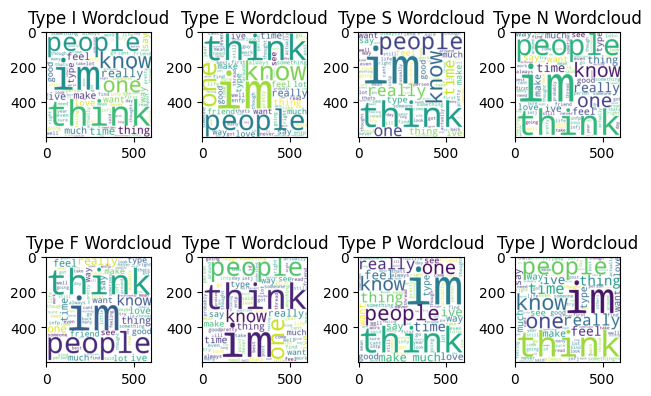

In [126]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

dfs = [ie_popwords, ie_popwords, sn_popwords, sn_popwords, ft_popwords, ft_popwords, pj_popwords, pj_popwords]
letters = ["I", "E", "S", "N", "F", "T", "P", "J"]

for wordcounts, letter, i in zip(dfs, letters, range(1, 9)):
    temp = wordcounts.loc[letter,].sort_values(ascending = False)[:100]
    wordcloud = WordCloud(width = 600, height = 600,
                    background_color ='white',
                    stopwords = STOPWORDS,
                    collocations=False,
                    min_font_size = 10).generate(''.join([((str(idx) + " ")* temp[idx]).strip() for idx in temp.index]))
    
    # plot the WordCloud image    
    plt.subplot(2,4,i)
    plt.imshow(wordcloud)
    plt.title(f"Type {letter} Wordcloud")

plt.tight_layout()    
plt.show()

For EDA, we would like to know:
1. Total number of posts by each MBTI type
2. Our data's distribution of MBTI type
3. General population's distribution of MBTI type
4. Break MBTI type down into each individual letter (I/E, N/S, F/T, P/J)

This will allow us to know the general breakdown of our data, if there are underrepresented classes, and if our data matches that of the general population. To summarize, our data has a very different MBTI type breakdown as opposed to the general population, it seems to be the opposite of it. Where a certain MBTI type is more common in the world, it is less likely to appear in our dataset. 

Breaking this down into individual MBTI letters, this distinction between our sample and the general population is less severe for J/P (+- 15%) and T/F (+- 5%) personality types, but is still pretty skewed for S/N (+-60%) and I/E (+-25%). 

To proceed, we can either:
1. Create a model with our current dataset which would not be optimal when applied to the general population
2. Create data augmentations for underrepresented personality types such that it matches the general population and train a model on it

# Feature Engineering & Modelling (Baseline)

We will be using TF-IDF for feature engineering in this project. TF-IDF is used since it is a common technique in NLP which takes into account word frequency and how important a word is for a certain document.

In [30]:
# TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features = 10000)
tfidf = vectorizer.fit_transform(X)
tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf)

tfidf_df.shape

(8675, 10000)

# Modelling 

We will try out two different machine learning models:
1. Random Forest Classifier
2. Logistic Regression

In [31]:
X_train = tfidf_df.sample(frac=0.8, random_state=25)
X_test = tfidf_df.drop(X_train.index)
# X_train = count_df.sample(frac=0.8, random_state=25)
# X_test = count_df.drop(X_train.index)

ie_y = mbti["I/E"].apply(lambda x: 0 if x == "I" else 1)
ie_y_train = ie_y[X_train.index]
ie_y_test = ie_y.drop(X_train.index)

sn_y = mbti["S/N"].apply(lambda x: 0 if x == "S" else 1)
sn_y_train = sn_y[X_train.index]
sn_y_test = sn_y.drop(X_train.index)

ft_y = mbti["F/T"].apply(lambda x: 0 if x == "F" else 1)
ft_y_train = ft_y[X_train.index]
ft_y_test = ft_y.drop(X_train.index)

pj_y = mbti["P/J"].apply(lambda x: 0 if x == "P" else 1)
pj_y_train = pj_y[X_train.index]
pj_y_test = pj_y.drop(X_train.index)

In [32]:
def power(x):
    return sum([int(x[i])*2**(len(x)-i-1) for i in range(len(x))])

## Random Forest Classifier

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

classifier = RandomForestClassifier(max_depth = 4)

# I/E
classifier.fit(X_train, ie_y_train)
ie_y_pred = classifier.predict(X_test)

# S/N
classifier.fit(X_train, sn_y_train)
sn_y_pred = classifier.predict(X_test)

# F/T
classifier.fit(X_train, ft_y_train)
ft_y_pred = classifier.predict(X_test)

# P/J
classifier.fit(X_train, pj_y_train)
pj_y_pred = classifier.predict(X_test)

preds = pd.concat([ie_y_test.reset_index(drop=True),sn_y_test.reset_index(drop=True),ft_y_test.reset_index(drop=True),
                   pj_y_test.reset_index(drop=True),pd.Series(ie_y_pred),pd.Series(sn_y_pred),
                   pd.Series(ft_y_pred),pd.Series(pj_y_pred)], axis = 1)
preds = preds.rename(columns = {"I/E":"ie_test", "S/N":"sn_test", "F/T":"ft_test", "P/J":"pj_test", 
                        0:"ie_pred", 1:"sn_pred", 2:"ft_pred", 3: "pj_pred"})

print("I/E accuracy: ", np.round((preds["ie_test"] == preds["ie_pred"]).mean() * 100, 2))
print("S/N accuracy: ", np.round((preds["sn_test"] == preds["sn_pred"]).mean() * 100, 2))
print("F/T accuracy: ", np.round((preds["ft_test"] == preds["ft_pred"]).mean() * 100, 2))
print("P/J accuracy: ", np.round((preds["pj_test"] == preds["pj_pred"]).mean() * 100, 2))

combined_test = preds["ie_test"].astype(str) + preds["sn_test"].astype(str) + preds["ft_test"].astype(str) + preds["pj_test"].astype(str) 
combined_pred = preds["ie_pred"].astype(str) + preds["sn_pred"].astype(str) + preds["ft_pred"].astype(str) + preds["pj_pred"].astype(str) 
y_true = combined_test.apply(lambda x: power(x))
y_pred = combined_pred.apply(lambda x: power(x))
print("Overall accuracy: ", f1_score(y_true, y_pred, average = 'micro'))
print("F1 score: ", f1_score(y_true, y_pred, average = 'weighted'))

I/E accuracy:  75.33
S/N accuracy:  86.74
F/T accuracy:  67.26
P/J accuracy:  60.92
Overall accuracy:  0.261671469740634
F1 score:  0.13549046683861005


## Logistic Regression

In [65]:
from sklearn.linear_model import LogisticRegression

for penalty in (['l2']):
    for C in np.arange(1.2,2,0.2):
        print(penalty, C)
        classifier = LogisticRegression(penalty = penalty, C=C)

        # I/E
        classifier.fit(X_train, ie_y_train)
        ie_y_pred = classifier.predict(X_test)

        # S/N
        classifier.fit(X_train, sn_y_train)
        sn_y_pred = classifier.predict(X_test)

        # F/T
        classifier.fit(X_train, ft_y_train)
        ft_y_pred = classifier.predict(X_test)

        # P/J
        classifier.fit(X_train, pj_y_train)
        pj_y_pred = classifier.predict(X_test)

        preds = pd.concat([ie_y_test.reset_index(drop=True),sn_y_test.reset_index(drop=True),ft_y_test.reset_index(drop=True),
                        pj_y_test.reset_index(drop=True),pd.Series(ie_y_pred),pd.Series(sn_y_pred),
                        pd.Series(ft_y_pred),pd.Series(pj_y_pred)], axis = 1)
        preds = preds.rename(columns = {"I/E":"ie_test", "S/N":"sn_test", "F/T":"ft_test", "P/J":"pj_test", 
                                0:"ie_pred", 1:"sn_pred", 2:"ft_pred", 3: "pj_pred"})

        print("I/E accuracy: ", np.round((preds["ie_test"] == preds["ie_pred"]).mean() * 100, 2))
        print("S/N accuracy: ", np.round((preds["sn_test"] == preds["sn_pred"]).mean() * 100, 2))
        print("F/T accuracy: ", np.round((preds["ft_test"] == preds["ft_pred"]).mean() * 100, 2))
        print("P/J accuracy: ", np.round((preds["pj_test"] == preds["pj_pred"]).mean() * 100, 2))

        combined_test = preds["ie_test"].astype(str) + preds["sn_test"].astype(str) + preds["ft_test"].astype(str) + preds["pj_test"].astype(str) 
        combined_pred = preds["ie_pred"].astype(str) + preds["sn_pred"].astype(str) + preds["ft_pred"].astype(str) + preds["pj_pred"].astype(str) 
        y_true = combined_test.apply(lambda x: power(x))
        y_pred = combined_pred.apply(lambda x: power(x))
        print("Overall accuracy: ", f1_score(y_true, y_pred, average = 'micro'))
        print("F1 score: ", f1_score(y_true, y_pred, average = 'weighted'))

l2 1.2
I/E accuracy:  82.36
S/N accuracy:  88.07
F/T accuracy:  84.38
P/J accuracy:  77.64
Overall accuracy:  0.5129682997118156
F1 score:  0.47136557847245925
l2 1.4
I/E accuracy:  82.54
S/N accuracy:  88.3
F/T accuracy:  84.32
P/J accuracy:  77.69
Overall accuracy:  0.5170028818443804
F1 score:  0.47780205357458067
l2 1.5999999999999999
I/E accuracy:  82.77
S/N accuracy:  88.53
F/T accuracy:  84.15
P/J accuracy:  77.69
Overall accuracy:  0.5198847262247839
F1 score:  0.4831369258652781
l2 1.7999999999999998
I/E accuracy:  83.0
S/N accuracy:  88.7
F/T accuracy:  84.03
P/J accuracy:  77.23
Overall accuracy:  0.5181556195965418
F1 score:  0.483381203245694


# Conclusion

We have a highly imbalanced dataset with 21.1% of our colleced MBTI types being INFP and only 0.4% being ESTJ. Breaking this into individual letters, our dataset is imbalanced with S/N personality type having a +-60% difference in representation and I/E personality type having a +-25% difference in representation. This means that we should be using F-1 score as our metric to measure model performance to take into account class imbalances. 

We tried out two different machine learning models: Random forest classification and logistic regression. Logistic regression performs better in both accuracy and F-1 score in our case, with the best model having parameter C = 1.8. This gives an overall accuracy of 51.82% and an F-1 score of 48.34%. Breaking this down into individual letters, however, we get an accuracy of 83.00% for predicting I/E, 88.70% for predicting S/N, 84.03% for predicting F/T, and 77.23% for predicting P/J. 

Through this project, I learned that we can predict a person's personality type solely based on their chats, without even looking at their behavior in real life. A next step for this project would be to implement Deep Learning models into this. A reason why this was not done this project is due to lack of resources. I tried training BERT on our corpus and making predictions with it, but training takes too much time given my limited resources and is not feasible in this project. 